In [200]:
# The convolutional neural network in this document has been inspired by Mikkel N. Schmidt's example.

In [201]:
#%% Import libraries
import numpy as np
import pandas as pd
from numpy import genfromtxt
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pylab as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Load training and test dataframes & TF-IDF matrices

In [202]:
# Load sentences and labels
train = pd.read_csv(r'train_dataframe.csv')
test = pd.read_csv(r'test_dataframe.csv')

In [203]:
train_labels = train["Labels"].tolist()
test_labels = test["Labels"].tolist()

In [204]:
train_tf_idf = pd.read_csv(r'DTTFIDFM_train.csv')
test_tf_idf = pd.read_csv(r'DTTFIDFM_test.csv')

train_tf_idf = train_tf_idf.drop('Unnamed: 0', axis=1)
test_tf_idf = test_tf_idf.drop('Unnamed: 0', axis=1)

In [205]:
train_tf_idf_numpy = train_tf_idf.to_numpy()
test_tf_idf_numpy = test_tf_idf.to_numpy()

# CNN

## Load SVD-matrix:

In [206]:
# Load SVD-matrix from csv-file
V_500 = genfromtxt('V500.csv', delimiter=',')

## Sentence LSA embedding

In [207]:
def sentence_LSA_embedding(TF_IDF_matrix_numpy, V_k):
    liste_LSA_vektorer = []
    for i in range(TF_IDF_matrix_numpy.shape[0]):
        lsa_vector = np.dot(TF_IDF_matrix_numpy[i], V_k)
        liste_LSA_vektorer.append(lsa_vector)
    return np.array(liste_LSA_vektorer)

In [208]:
train_lsa = sentence_LSA_embedding(train_tf_idf_numpy, V_500)
test_lsa = sentence_LSA_embedding(test_tf_idf_numpy, V_500)

## Make tensors

In [209]:
# Convert inputs
train_input_tensor = torch.tensor(train_lsa, dtype=torch.float32)  # Shape: (num_train_sentences, 200)
test_input_tensor = torch.tensor(test_lsa, dtype=torch.float32)    # Shape: (num_test_sentences, 200)

# Convert labels
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # Shape: (num_train_sentences,)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)    # Shape: (num_test_sentences,)

In [210]:
# Reshape the tensors for CNN input (adding the channel dimension)
train_input_tensor = train_input_tensor.unsqueeze(1)  # Shape: (num_train_sentences, 1, 200)
test_input_tensor = test_input_tensor.unsqueeze(1)    # Shape: (num_test_sentences, 1, 200)

In [211]:
batch_size = 128
# Create datasets
train_dataset = TensorDataset(train_input_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_input_tensor, test_labels_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for testing

## Build the CNN

In [228]:
num_epochs = 33
learning_rate = 0.0006
weight_decay = 0.0001

In [229]:
#%% Device
# Run on GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [230]:
#%% Neural network
net = torch.nn.Sequential(
    # Convolutional layer
    torch.nn.Conv1d(1, 16, kernel_size=3), # 500 - 3 + 1 = 498
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),
    torch.nn.MaxPool1d(kernel_size=2), # 498 // 2 = 249

    torch.nn.Flatten(), # 128, 16*249 = 3984

    # First linear
    torch.nn.Linear(3984, 1992), # 128, 1992
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.3),

    # Second linear
    torch.nn.Linear(1992, 996), # 996
    torch.nn.ReLU(),

    # Third layer
    torch.nn.Linear(996, 498), # 498
    torch.nn.ReLU(),
    torch.nn.Linear(498, 2) # 249

    ).to(device)

In [231]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2454, 1: 2475}


In [232]:
#%% Loss and optimizer
class_weights = torch.tensor([1., 1.]).to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights) # 
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [233]:
# %% Load trained network from file
# net.load_state_dict(torch.load('netV2.pt'))

## Train and test

In [234]:
#%% Train
train_loss = {}
test_loss = {}
train_accuracy = {}
test_accuracy = {}
step = 0

test_labels_dronning = {}
test_labels_statsminister = {}

scheduler = CosineAnnealingLR(optimizer, T_max=50)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        net.train()

        # Put data on GPU 
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Compute loss and take gradient step
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, dim=1)

        running_loss += loss.item()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Print accuracy for epoch            
    epoch_loss = running_loss / len(train_loader)

    train_loss[epoch] = epoch_loss

    epoch_accuracy = 100 * correct / total

    train_accuracy[epoch] = epoch_accuracy

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training loss: {epoch_loss:.4f}, Training accuracy: {epoch_accuracy:.2f}%")

    # Evaluate the model
    net.eval()
    correct = 0
    total = 0
    running_loss_test = 0.0

    dronning_correct = 0
    dronning_total = 0
    statsminister_correct = 0
    statsminister_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Put data on GPU 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = net(inputs).float()
            
            predicted = torch.argmax(outputs, dim=1)

            loss = loss_function(outputs, labels)
            
            running_loss_test += loss.item()

            # Count correct predictions
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Label-wise counting
            dronning_correct += (((predicted == 0) & (labels == 0))).sum().item()
            dronning_total += (labels == 0).sum().item()

            statsminister_correct += (((predicted == 1) & (labels == 1))).sum().item()
            statsminister_total += (labels == 1).sum().item()

        epoch_loss_test = running_loss_test / len(test_loader)
        test_loss[epoch] = epoch_loss_test

    test_accuracy_score = 100 * correct / total
    
    dronning_acc = 100.0 * dronning_correct / dronning_total
    statsminister_acc = 100.0 * statsminister_correct / statsminister_total

    # Store label-wise accuracy for testing
    test_labels_dronning[epoch] = dronning_acc
    test_labels_statsminister[epoch] = statsminister_acc

    test_accuracy[epoch] = test_accuracy_score

    print(f"Test loss: {epoch_loss_test:.4f}, Test accuracy: {test_accuracy_score:.2f}%")
    print(f"Dronning (0) accuracy: {dronning_acc:.2f}% - Statsminister (1) accuracy: {statsminister_acc:.2f}%")
    print()

    scheduler.step()

Epoch 1/33
Training loss: 0.6973, Training accuracy: 50.21%
Test loss: 0.6933, Test accuracy: 49.36%
Dronning (0) accuracy: 0.00% - Statsminister (1) accuracy: 100.00%

Epoch 2/33
Training loss: 0.6937, Training accuracy: 50.98%
Test loss: 0.6927, Test accuracy: 50.58%
Dronning (0) accuracy: 99.88% - Statsminister (1) accuracy: 0.00%

Epoch 3/33
Training loss: 0.6880, Training accuracy: 53.76%
Test loss: 0.6828, Test accuracy: 59.59%
Dronning (0) accuracy: 61.90% - Statsminister (1) accuracy: 57.21%

Epoch 4/33
Training loss: 0.6705, Training accuracy: 58.41%
Test loss: 0.6806, Test accuracy: 57.94%
Dronning (0) accuracy: 76.68% - Statsminister (1) accuracy: 38.72%

Epoch 5/33
Training loss: 0.6575, Training accuracy: 61.07%
Test loss: 0.6802, Test accuracy: 58.86%
Dronning (0) accuracy: 36.30% - Statsminister (1) accuracy: 82.00%

Epoch 6/33
Training loss: 0.6473, Training accuracy: 63.01%
Test loss: 0.6775, Test accuracy: 56.24%
Dronning (0) accuracy: 86.30% - Statsminister (1) accur

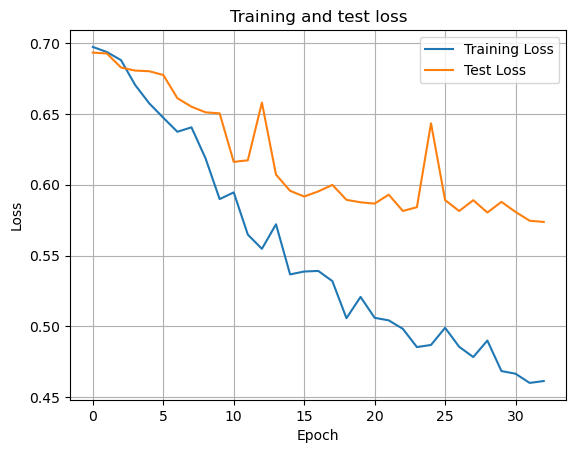

In [236]:
plt.plot(train_loss.values(), label="Training Loss")
plt.plot(test_loss.values(), label="Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.grid(True)

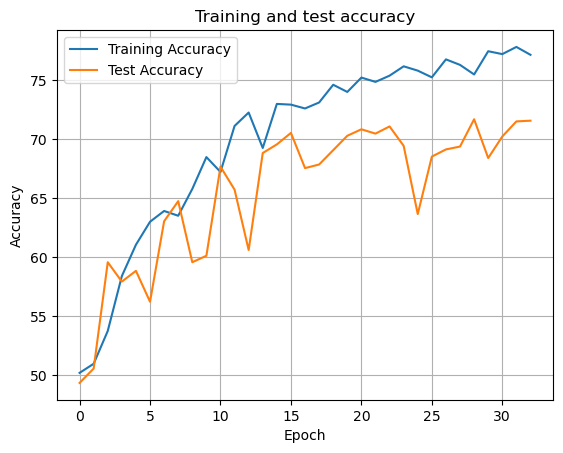

In [237]:
plt.plot(train_accuracy.values(), label="Training Accuracy")
plt.plot(test_accuracy.values(), label="Test Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and test accuracy")
plt.grid(True)

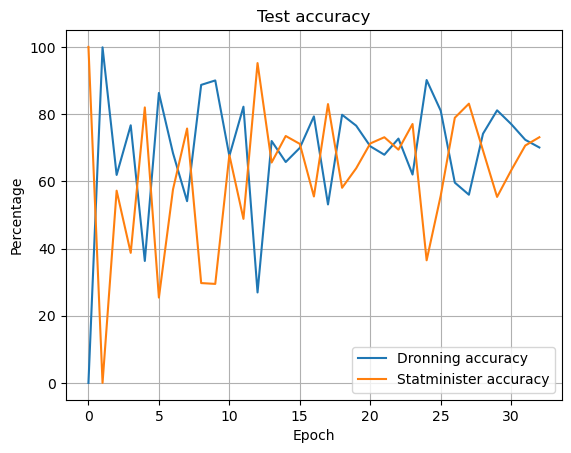

In [238]:
plt.plot(test_labels_dronning.values(), label="Dronning accuracy")
plt.plot(test_labels_statsminister.values(), label="Statminister accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Percentage")
plt.title("Test accuracy")
plt.grid(True)

In [235]:
# %% Save the trained model
# torch.save(net.state_dict(), 'netV2.pt')

## Confidence intervals for the proportions

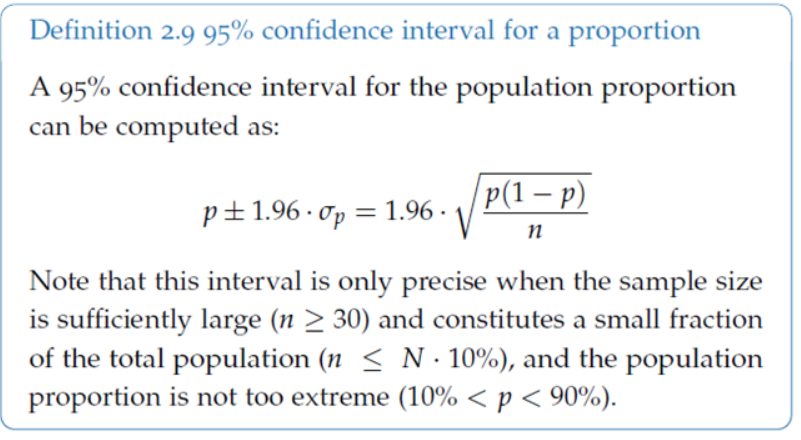

In [224]:
# Epoch 33/33
# Training loss: 0.4663, Training accuracy: 77.22%
# Test loss: 0.4663, Test accuracy: 70.85%
# Dronning (0) accuracy: 71.63% - Statsminister (1) accuracy: 70.04%

In [225]:
# Overall
x = 3170
n = len(test_labels)
p_hat = x/n

# Beregner 95% konfidensinterval
std_hat = np.sqrt((p_hat*(1-p_hat)/n))
# fra standardnormalfordeling
z_kvartil = 1.96

KI = p_hat + np.array([-1,1]) * z_kvartil * std_hat
print(f"{KI=}")

KI=array([nan, nan])


C:\Users\chris\AppData\Local\Temp\ipykernel_16300\2592638242.py:7: RuntimeWarning: invalid value encountered in sqrt
  std_hat = np.sqrt((p_hat*(1-p_hat)/n))


In [226]:
# PM
x = 3170
n = 3457
p_hat = x/n

# Beregner 95% konfidensinterval
std_hat = np.sqrt((p_hat*(1-p_hat)/n))
# fra standardnormalfordeling
z_kvartil = 1.96

KI = p_hat + np.array([-1,1]) * z_kvartil * std_hat
print(f"{KI=}")

KI=array([0.90778238, 0.92617771])


In [227]:
# Queen
x = 3170
n = 3457
p_hat = x/n

# Beregner 95% konfidensinterval
std_hat = np.sqrt((p_hat*(1-p_hat)/n))
# fra standardnormalfordeling
z_kvartil = 1.96

KI = p_hat + np.array([-1,1]) * z_kvartil * std_hat
print(f"{KI=}")

KI=array([0.90778238, 0.92617771])
